In [49]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm,trange,tqdm_notebook
import itertools

import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.metrics import mean_squared_error,f1_score
import warnings 

In [50]:
plt.style.use('ggplot')
plt.rc('font', family = 'malgun gothic')
warnings.filterwarnings(action = 'ignore')

In [51]:
df = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/data.csv')
origin = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/origin_data.csv')
sub = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/sample_submission.csv')

In [52]:
df = pd.concat([df,origin])
df

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...,...
1860,1861,Richenderfer,plate,1.01,1500.0,-0.0218,15.0,120.0,10.0,9.4
1861,1862,Richenderfer,plate,1.01,1500.0,-0.0434,15.0,120.0,10.0,10.4
1862,1863,Richenderfer,plate,1.01,2000.0,-0.0109,15.0,120.0,10.0,10.8
1863,1864,Richenderfer,plate,1.01,2000.0,-0.0218,15.0,120.0,10.0,10.9


The dataset for this competition (both train and test) was generated from a deep learning model trained on the Predicting Critical Heat Flux dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

Files

    data.csv - the competition dataset; your objective is to impute the missing values of the feature x_e_out [-] (equilibrium quality)
    sample_submission.csv - a sample submission file in the correct format

### Evaluations : RMSE

# 이번 Playground의 주 목적
- 데이터프레임에 있는 다양한 결측값을 어떻게 채울 것이냐 
- 타겟값은 x_e_out 
- 컬럼들의 특수 기호를 어떻게 제거하여 사용에 용이하게 할 것이냐 

# 메모리 용량 줄이기 

In [53]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [54]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.81 MB
Memory usage after optimization is: 1.28 MB
Decreased by 54.5%


# 행 별 갤측값 갯수 

In [55]:
max_na = len(df.columns)

print(f'행 별 결측값 갯수의 범위 : 0 ~ {max_na}')

행 별 결측값 갯수의 범위 : 0 ~ 10


Text(0.5, 0, '결측값 갯수')

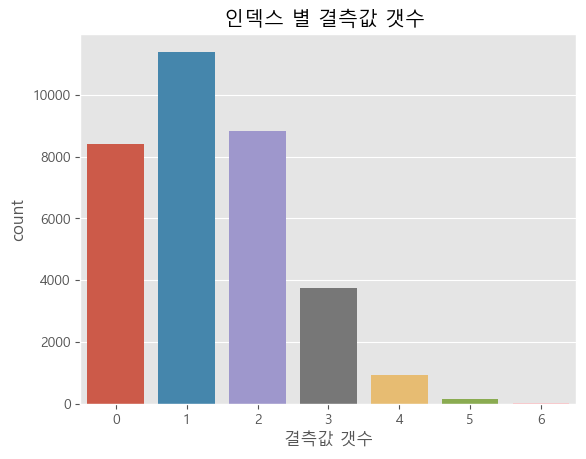

In [56]:
na_df = pd.DataFrame(df.isna().sum(axis = 1)).reset_index() # 인덱스 별 결측값 갯수 

sns.countplot(data = na_df,
                x = 0)
plt.title('인덱스 별 결측값 갯수 ')
plt.xlabel('결측값 갯수')

* 결측치를 채워야 하는 인덱스들은 총 24000 개 정도가 된다. 예측을 위해 

* 예전에는 결측치를 모두 평균, 중앙값, 랜덤한 난수 등으로 채워왔으나 머신러닝을 통해 보간하는 방법도 있다.

# Columns 명 변경하기 

In [57]:
df.columns = df.columns.map(lambda x: x.split('[')[0].strip())

df.columns

Index(['id', 'author', 'geometry', 'pressure', 'mass_flux', 'x_e_out', 'D_e',
       'D_h', 'length', 'chf_exp'],
      dtype='object')

In [58]:
df = df.drop('id',axis =1)

In [59]:
submission_obj = df['x_e_out']
df = df.drop('x_e_out',axis = 1)

In [60]:
missing_value = [col for col in df.columns if df[col].isna().sum() > 0]
missing_value

['author', 'geometry', 'pressure', 'mass_flux', 'D_e', 'D_h', 'length']

In [61]:
cat_cols = missing_value[:2]
num_cols = missing_value[2:]

In [62]:
splits = 5

cv = KFold(n_splits = splits, shuffle = True,
            random_state = 42)

param_grid = {
'learning_rate': [0.1],
'num_leaves': [31, 50, 100],
'max_depth': [3, 5, 7],
'objective': ['multiclass'],
'metric': ['multi_logloss'],
'verbosity': [-1],
'num_boost_round': [300],
'early_stopping_rounds': [10]
}

param_keys = list(param_grid.keys())
param_value = list(param_grid.values())


labels = {}
reverse_labels = {}
result_params = {}

for col in cat_cols:

    cond = df[col].isna() # bool 형태로 condition 저장 
    
    
    data = pd.get_dummies(df.drop(col,axis = 1))
    data[col] = df[col]
    
    train = data[~cond]
    test = data[cond]
    
    # train = df[~cond] # 학습 데이터는 해당 col 이 결측값이 아닌 경우 
    # test = pd.get_dummies(df[cond].drop(col,axis = 1)) # 테스트 데이터는 해당 col 이 결측값인 경우
    
    label = {v:k for k,v in enumerate(train[col].unique())} # 범주형 변수 학습 및 예측을 위해 라벨링
    reverse_label = {k:v for k,v in enumerate(train[col].unique())} # 예측 후 원래형태로 돌리기 위한 역 라벨링
    
    
    labels[col] = label # col 별 라벨링 결과를 딕셔너리 형태에 저장 
    reverse_labels[col] = reverse_label
    
    X = pd.get_dummies(train.drop(col,axis = 1)) # col 을 제외한 범주형 변수는 더미 변수화
    y = train[col].map(label) #label encoding 

    # 빈 딕셔너리 형태 생성 

    train_avg_scores = {} 
    test_avg_scores = {}
    best_iter = {}
    
    param_combinations = itertools.product(*param_value) # itertools 를 통해 param_grid 의 모든 조건 수 생성 
    
    for param in tqdm_notebook(param_combinations): # for 문 이전에 만든 param_grid 를 iteration 하며 gridsearch 와 같이 구현 

        new_param_grid = dict(zip(param_keys,param)) # param_grid 에 있는 조건에 따라 new_param_grid 생성
        new_param_grid['num_class'] = y.nunique()
        
        # Fold set 을 돌며 score 가 담길 빈 변수 생성 
        
        train_score = 0 
        test_score = 0
        iter = 0
                
        for i,(train_idx,test_idx) in enumerate(cv.split(X,y)):
            
            
            x_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
            x_test,y_test = X.iloc[test_idx],y.iloc[test_idx]
            
            train_data = lgb.Dataset(data = x_train, label = y_train)
            test_data = lgb.Dataset(data = x_test, label = y_test)
            
            model = lgb.train(new_param_grid,train_data,
                        valid_sets = [test_data], verbose_eval = False)
            
            cv_best_iter = model.best_iteration # early stopping 이후 best_iteration 수를 생성 
            
            # multi class 분류 문제는 해당 class 별 probability 로 예측 
            
            train_pred_prob = model.predict(x_train, num_iteration = cv_best_iter)
            test_pred_prob = model.predict(x_test, num_iteration = cv_best_iter)
            
            # np.argmax 를 통해 class 별 probability 가 가장 높은 인덱스를 예측값 리스트 형태로 저장 
            
            train_pred = np.argmax(train_pred_prob,axis = 1)
            test_pred = np.argmax(test_pred_prob,axis = 1)
            
            # Fold 별 평균 score 저장 
            
            train_score += f1_score(y_train,train_pred,average = 'micro') 
            test_score += f1_score(y_test,test_pred, average = 'micro') 
            iter += cv_best_iter
        
        # iteration 동안 생성된 평균 score를 딕셔너리에 저장     
        
        train_avg_scores[param] = train_score / splits 
        test_avg_scores[param] = test_score / splits
        best_iter[param] = iter / splits


    # iteration 돌며 생긴 다양한 parmeter 값들 중 가장 test_f1_score가 높은 key 를 test_best_params에 저장 
    test_best_params = max(test_avg_scores, key = test_avg_scores.get)

    # 다시 lgb_train 에 적용 할 수 있도록 딕셔너리 컴프리헨션으로 딕셔너리 형태로 저장 

    best_params = {v:k for k,v in zip(list(test_best_params),list(new_param_grid.keys())[:-1])}
    
    del best_params['early_stopping_rounds'] # test 할 때 early_stopping 기능은 사용하지 않을 것이니 제거
    best_params['num_boost_round'] = int(best_iter[test_best_params]) # num_boost_round 는 해당 params 의 best_iteations 수로 지정 
    best_params['num_class'] =  y.nunique() # num_class 지정 
    result_params[col] = best_params


    print(f'{col} 의 Best Parameter 는 {best_params}')
    print(f'{col} 의 Best iteration 은 {best_iter[test_best_params]}')
    print('--'*20)
    print(f'{col} 의 {splits} 번 교차 검증 시 점수')
    print(f'Train F1 score : {round(train_avg_scores[test_best_params],2)}')
    print(f'Test F1 score : {round(test_avg_scores[test_best_params],2)}')
    print('--'*20)

0it [00:00, ?it/s]

author 의 Best Parameter 는 {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'multiclass', 'metric': 'multi_logloss', 'verbosity': -1, 'num_boost_round': 112, 'num_class': 10}
author 의 Best iteration 은 112.4
----------------------------------------
author 의 5 번 교차 검증 시 점수
Train F1 score : 0.96
Test F1 score : 0.95
----------------------------------------


0it [00:00, ?it/s]

geometry 의 Best Parameter 는 {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'multiclass', 'metric': 'multi_logloss', 'verbosity': -1, 'num_boost_round': 121, 'num_class': 3}
geometry 의 Best iteration 은 121.0
----------------------------------------
geometry 의 5 번 교차 검증 시 점수
Train F1 score : 0.99
Test F1 score : 0.99
----------------------------------------


In [63]:
for col in cat_cols:
    
    
    data = df.copy()
    
    cond = data[col].isna()
    
    feature_data = pd.get_dummies(data.loc[~cond].drop(col,axis = 1))
    label_data = data.loc[~cond,col].map(labels[col])
    
    test = pd.get_dummies(data[cond])
    
    lgb_data = lgb.Dataset(data = feature_data,
                label = label_data)
    
    model = lgb.train(result_params[col], lgb_data)
    
    prob = model.predict(test)
    pred = np.argmax(prob, axis = 1)
    
    df[col] = df[col].map(labels[col])
    df.loc[cond,col] = pred
    
    df[col] = df[col].map(reverse_labels[col])

In [64]:
df

,author,geometry,pressure,mass_flux,D_e,D_h,length,chf_exp
0,Thompson,tube,7.000000,3770.0,NaN,10.796875,432.0,3.599609
1,Thompson,tube,NaN,6048.0,10.296875,10.296875,762.0,6.199219
2,Thompson,tube,13.789062,2034.0,7.699219,7.699219,457.0,2.500000
3,Beus,annulus,13.789062,3680.0,5.601562,15.203125,2134.0,3.000000
4,Weatherhead,tube,13.789062,686.0,11.101562,11.101562,457.0,2.800781
...,...,...,...,...,...,...,...,...
1860,Richenderfer,plate,1.009766,1500.0,15.000000,120.000000,10.0,9.398438
1861,Richenderfer,plate,1.009766,1500.0,15.000000,120.000000,10.0,10.398438
1862,Richenderfer,plate,1.009766,2000.0,15.000000,120.000000,10.0,10.796875
1863,Richenderfer,plate,1.009766,2000.0,15.000000,120.000000,10.0,10.898438


In [65]:
splits = 5

cv = KFold(n_splits = splits, shuffle = True,
            random_state = 42)

param_grid = {
'learning_rate': [0.1],
'num_leaves': [31, 50, 100],
'max_depth': [3, 5, 7],
'objective': ['regression'],
'metric': ['mse'],
'verbosity': [-1],
'num_boost_round': [300],
'early_stopping_rounds': [10]
}


param_keys = list(param_grid.keys())
param_value = list(param_grid.values())

result_params = {}

for _,col in enumerate(num_cols):
    
    cond = df[col].isna() # bool 형태로 condition 저장 

    data = pd.get_dummies(df.drop(col,axis = 1))
    data[col] = df[col]
    
    train = data[~cond]
    test = data[cond]

    
    X = train.drop(col,axis = 1) # col 을 제외한 범주형 변수는 더미 변수화
    y = train[col] #label encoding 
    

    # 빈 딕셔너리 형태 생성 

    train_avg_scores = {} 
    test_avg_scores = {}
    best_iter = {}
    
        
    
    if _ == 0:
        
        param_combinations = itertools.product(*param_value) # itertools 를 통해 param_grid 의 모든 조건 수 생성 
        num_combinations = len(list(itertools.product(*param_value)))
        
        print('조건 수 :',num_combinations)
        print('fitting 수 :', num_combinations * splits)
        
    else:
        
        param_combinations = itertools.product(*param_value) # itertools 를 통해 param_grid 의 모든 조건 수 생성 

    
    for param in tqdm(param_combinations): # for 문 이전에 만든 param_grid 를 iteration 하며 gridsearch 와 같이 구현 

        new_param_grid = dict(zip(param_keys,param)) # param_grid 에 있는 조건에 따라 new_param_grid 생성
        
        
        # Fold set 을 돌며 score 가 담길 빈 변수 생성 
        
        train_score = 0 
        test_score = 0
        iter = 0
                
        for i,(train_idx,test_idx) in enumerate(cv.split(X,y)):
            
            
            x_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
            x_test,y_test = X.iloc[test_idx],y.iloc[test_idx]

            train_data = lgb.Dataset(data = x_train, label = y_train)
            test_data = lgb.Dataset(data = x_test, label = y_test)
            
            model = lgb.train(new_param_grid,train_data,
                        valid_sets = [test_data], verbose_eval = False)
            
            cv_best_iter = model.best_iteration # early stopping 이후 best_iteration 수를 생성 
            
            # multi class 분류 문제는 해당 class 별 probability 로 예측 
            
            train_pred = model.predict(x_train, num_iteration = cv_best_iter)
            test_pred= model.predict(x_test, num_iteration = cv_best_iter)
            
            # Fold 별 평균 score 저장 
            
            train_score += mean_squared_error(y_train,train_pred) 
            test_score += mean_squared_error(y_test,test_pred) 
                        
            iter += cv_best_iter
        
        # iteration 동안 생성된 평균 score를 딕셔너리에 저장     
        
        train_avg_scores[param] = train_score / splits 
        test_avg_scores[param] = test_score / splits
        best_iter[param] = iter / splits


    # iteration 돌며 생긴 다양한 parmeter 값들 중 가장 test_f1_score가 높은 key 를 test_best_params에 저장 
    test_best_params = max(test_avg_scores, key = test_avg_scores.get)

    # 다시 lgb_train 에 적용 할 수 있도록 딕셔너리 컴프리헨션으로 딕셔너리 형태로 저장 

    best_params = {v:k for k,v in zip(list(test_best_params),list(new_param_grid.keys())[:-1])}
    
    print(best_params)
    
    best_params['num_boost_round'] = int(best_iter[test_best_params]) # num_boost_round 는 해당 params 의 best_iteations 수로 지정 
    result_params[col] = best_params


    print(f'{col} 의 Best Parameter 는 {best_params}')
    print(f'{col} 의 Best iteration 은 {best_iter[test_best_params]}')
    print('--'*20)
    print(f'{col} 의 {splits} 번 교차 검증 시 점수')
    print(f'Train mse : {round(train_avg_scores[test_best_params],2)}')
    print(f'Test mse : {round(test_avg_scores[test_best_params],2)}')
    print('--'*20)

조건 수 : 9
fitting 수 : 45


9it [00:19,  2.22s/it]


{'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 300}
pressure 의 Best Parameter 는 {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 299}
pressure 의 Best iteration 은 299.8
----------------------------------------
pressure 의 5 번 교차 검증 시 점수
Train mse : 4.08
Test mse : 4.28
----------------------------------------


9it [00:12,  1.39s/it]


{'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 300}
mass_flux 의 Best Parameter 는 {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 299}
mass_flux 의 Best iteration 은 299.0
----------------------------------------
mass_flux 의 5 번 교차 검증 시 점수
Train mse : 1534324.85
Test mse : 1592383.69
----------------------------------------


9it [00:20,  2.33s/it]


{'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 300}
D_e 의 Best Parameter 는 {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 299}
D_e 의 Best iteration 은 299.6
----------------------------------------
D_e 의 5 번 교차 검증 시 점수
Train mse : 0.9
Test mse : 1.0
----------------------------------------


9it [00:15,  1.75s/it]


{'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 7, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 300}
D_h 의 Best Parameter 는 {'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 7, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 167}
D_h 의 Best iteration 은 167.8
----------------------------------------
D_h 의 5 번 교차 검증 시 점수
Train mse : 4.94
Test mse : 10.61
----------------------------------------


9it [00:23,  2.63s/it]

{'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 300}
length 의 Best Parameter 는 {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'num_boost_round': 299}
length 의 Best iteration 은 299.8
----------------------------------------
length 의 5 번 교차 검증 시 점수
Train mse : 52184.25
Test mse : 54977.15
----------------------------------------


In [68]:
df.describe()

,pressure,mass_flux,D_e,D_h,length,chf_exp
count,2.905700e+04,28718.0,2.802100e+04,2.892000e+04,28750.0,3.350900e+04
mean,inf,inf,inf,inf,inf,inf
std,4.332031e+00,inf,5.273438e+00,1.992188e+01,inf,1.984375e+00
min,9.997559e-02,0.0,1.000000e+00,1.000000e+00,10.0,7.998047e-01
25%,6.890625e+00,1519.0,5.000000e+00,5.601562e+00,318.0,2.400391e+00
50%,1.103125e+01,2728.0,7.800781e+00,1.029688e+01,610.0,3.400391e+00
75%,1.378906e+01,4068.0,1.079688e+01,1.150000e+01,914.0,4.601562e+00
max,2.068750e+01,7976.0,3.750000e+01,1.200000e+02,3048.0,1.929688e+01


In [71]:
num_cols = ['pressure','D_e','D_h']

In [72]:
for col in num_cols:
    
    data = pd.get_dummies(df.copy())
    
    cond = data[col].isna()
    
    feature_data = data.loc[~cond].drop(col,axis = 1)
    label_data = data.loc[~cond,col]
    
    test = data[cond].drop(col,axis = 1)
    
    lgb_data = lgb.Dataset(data = feature_data,
                label = label_data)
    
    model = lgb.train(result_params[col], lgb_data)
    
    pred = model.predict(test)
    
    df.loc[cond,col] = pred

# mass_flux 와 length 는 mse 가 너무 높았기에 중앙값으로 대치해보자 

In [75]:
for col in ['mass_flux', 'length']:
    
    cond = df[col].isna()
    
    df.loc[cond,col] = df.loc[cond,col].fillna(df.loc[~cond,col].median()) 

In [77]:
df['target'] = submission_obj

In [86]:
cond = df['target'].isna()

data = pd.get_dummies(df)

param_grid = {
    'learning_rate': [0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [3, 5, 7],
    'min_child_samples': [20, 50, 100],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'reg_alpha': [0.1],
    'reg_lambda':  [0.1],
    'verbosity': [-1],
    'n_estimators': [1000],
    'early_stopping_rounds': [10]
}


param_keys = list(param_grid.keys())
param_value = list(param_grid.values())

train = data[~cond]
test = data[cond].drop('target',axis = 1)

X,y = train.drop('target',axis = 1), train['target']

train_avg_scores = {} 
test_avg_scores = {}
best_iter = {}

splits = 5

cv = KFold(n_splits = splits, shuffle = True,
            random_state = 42)

param_combinations = itertools.product(*param_value) # itertools 를 통해 param_grid 의 모든 조건 수 생성 

for param in tqdm(param_combinations): # for 문 이전에 만든 param_grid 를 iteration 하며 gridsearch 와 같이 구현 

    new_param_grid = dict(zip(param_keys,param)) # param_grid 에 있는 조건에 따라 new_param_grid 생성
    
    # Fold set 을 돌며 score 가 담길 빈 변수 생성 
    
    train_score = 0 
    test_score = 0
    iter = 0
            
    for i,(train_idx,test_idx) in enumerate(cv.split(X,y)):
        
        
        x_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
        x_test,y_test = X.iloc[test_idx],y.iloc[test_idx]

        train_data = lgb.Dataset(data = x_train, label = y_train)
        test_data = lgb.Dataset(data = x_test, label = y_test)
        
        model = lgb.train(new_param_grid,train_data,
                    valid_sets = [test_data], verbose_eval = False)
        
        cv_best_iter = model.best_iteration # early stopping 이후 best_iteration 수를 생성 
        
        # multi class 분류 문제는 해당 class 별 probability 로 예측 
        
        train_pred = model.predict(x_train, num_iteration = cv_best_iter)
        test_pred= model.predict(x_test, num_iteration = cv_best_iter)
        
        # Fold 별 평균 score 저장 
        
        train_score += mean_squared_error(y_train,train_pred) 
        test_score += mean_squared_error(y_test,test_pred) 
                    
        iter += cv_best_iter
    
    # iteration 동안 생성된 평균 score를 딕셔너리에 저장     
    
    train_avg_scores[param] = train_score / splits 
    test_avg_scores[param] = test_score / splits
    best_iter[param] = iter / splits
    

# iteration 돌며 생긴 다양한 parmeter 값들 중 가장 test_f1_score가 높은 key 를 test_best_params에 저장 
test_best_params = max(test_avg_scores, key = test_avg_scores.get)

# 다시 lgb_train 에 적용 할 수 있도록 딕셔너리 컴프리헨션으로 딕셔너리 형태로 저장 

best_params = {v:k for k,v in zip(list(test_best_params),list(new_param_grid.keys())[:-1])}


best_params['num_boost_round'] = int(best_iter[test_best_params]) # num_boost_round 는 해당 params 의 best_iteations 수로 지정 
result_params['target'] = best_params

27it [00:39,  1.45s/it]


In [87]:
print(f'target 의 Best Parameter 는 {best_params}')
print(f'target 의 Best iteration 은 {best_iter[test_best_params]}')
print('--'*20)
print(f'target 의 {splits} 번 교차 검증 시 점수')
print(f'Train mse : {round(train_avg_scores[test_best_params],7)}')
print(f'Test mse : {round(test_avg_scores[test_best_params],7)}')
print('--'*20)

target 의 Best Parameter 는 {'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 3, 'min_child_samples': 50, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'verbosity': -1, 'n_estimators': 1000, 'num_boost_round': 338}
target 의 Best iteration 은 338.8
----------------------------------------
target 의 5 번 교차 검증 시 점수
Train mse : 0.0050318
Test mse : 0.0053496
----------------------------------------


In [88]:
data = lgb.Dataset(X,y)
model = lgb.train(result_params['target'], data)

result = model.predict(test)

In [89]:
sub['x_e_out [-]'] = result

In [90]:
sub

,id,x_e_out [-]
0,4,-0.010263
1,7,-0.080442
2,10,-0.048425
3,12,-0.009596
4,23,0.044800
...,...,...
10410,31633,0.067527
10411,31634,-0.048729
10412,31637,0.018883
10413,31640,-0.059481


In [91]:
sub.to_csv('하이퍼파라미터조정.csv',index = False)